# Cocoa Disease Classification

In [ ]:
# -----------------------------
# 1. UNZIP DATASET
# -----------------------------
import zipfile
import os

zip_path = '/content/drive/MyDrive/dataset.zip'         # Path to your zip file
extract_path = '/content/drive/MyDrive/dataset'         # Target folder to extract files

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed successfully.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or is corrupted.")
except FileNotFoundError:
    print("Error: ZIP file not found. Please check the path.")
except Exception as e:
    print(f"Unexpected error: {e}")

Extraction completed successfully.


In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import numpy as np

def augment_images(input_dir, output_dir, target_count):
    try:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # List of original images
        images = [img for img in os.listdir(input_dir)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Count existing images in output_dir
        existing = [img for img in os.listdir(output_dir)
                    if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        current_count = len(existing)

        print(f"Currently {current_count} images in '{output_dir}'")

        if current_count >= target_count:
            print(f"'{output_dir}' already has {current_count} images. Skipping augmentation.")
            return

        generated_count = 0

        while current_count < target_count:
            img_name = random.choice(images)
            img_path = os.path.join(input_dir, img_name)

            try:
                img = load_img(img_path)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                prefix = os.path.splitext(img_name)[0]

                # generate only one image per loop to control count
                for batch in datagen.flow(x, batch_size=1):
                    new_img = array_to_img(batch[0])
                    new_name = f"{prefix}_aug_{current_count + 1}.jpg"
                    new_img.save(os.path.join(output_dir, new_name))
                    current_count += 1
                    generated_count += 1
                    break

            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue

        print(f"Augmented {generated_count} new images. Final count in '{output_dir}': {current_count}")

    except Exception as e:
        print(f"Error during augmentation: {e}")

# Apply to both classes
augment_images('/content/drive/MyDrive/dataset/pod_borer', '/content/drive/MyDrive/new_dataset/pod_borer', 1500)
augment_images('/content/drive/MyDrive/dataset/black_pod_rot', '/content/drive/MyDrive/new_dataset/black_pod_rot', 1500)

Currently 0 images in '/content/drive/MyDrive/new_dataset/pod_borer'
Augmented 1500 new images. Final count in '/content/drive/MyDrive/new_dataset/pod_borer': 1500
Currently 0 images in '/content/drive/MyDrive/new_dataset/black_pod_rot'
Augmented 1500 new images. Final count in '/content/drive/MyDrive/new_dataset/black_pod_rot': 1500


In [ ]:
# -----------------------------
# 3. LOAD TRAINING & VALIDATION DATA
# -----------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2              # Use 20% of data for validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/new_dataset',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/new_dataset',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3600 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
# -----------------------------
# 4. BUILD A CNN MODEL
# -----------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: pod borer, black pod rot, healthy
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 575s 5s/step - accuracy: 0.4269 - loss: 1.0719 - val_accuracy: 0.6556 - val_loss: 0.7500
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.6487 - loss: 0.7851 - val_accuracy: 0.7311 - val_loss: 0.6573
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.6818 - loss: 0.7248 - val_accuracy: 0.7033 - val_loss: 0.6432
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.7111 - loss: 0.6568 - val_accuracy: 0.7656 - val_loss: 0.5896
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.7345 - loss: 0.5994 - val_accuracy: 0.7744 - val_loss: 0.5487
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7494 - loss: 0.5696 - val_accuracy: 0.7989 - val_loss: 0.5052
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7881 - loss: 0.5064 - val_accuracy: 0.8244 - val_loss: 0.4577
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.7820 - loss: 0.5134 - val_accu

In [ ]:
# -----------------------------
# 9. SAVE THE MODEL
# -----------------------------
model.save('/content/drive/MyDrive/cocoa_disease_model_updated.keras')
print("Model saved to Drive.")

Model saved to Drive.


Saving here-are-some-exceptional-benefits-of-cocoa-removebg-preview.png to here-are-some-exceptional-benefits-of-cocoa-removebg-preview (3).png


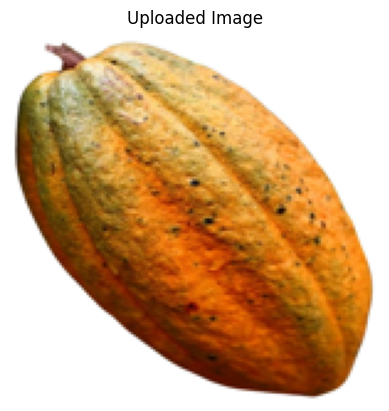

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Class: Pod_borer (88.46%)


In [ ]:
# -----------------------------
# 10. UPLOAD AND PREDICT SINGLE IMAGE
# -----------------------------
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload image
uploaded = files.upload()

# Load the uploaded image
for img_name in uploaded.keys():
    img_path = img_name
    img = Image.open(img_path).convert('RGB')

    img = img.resize((150, 150))  # Resize to match model input

    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Model expects batch

    # Load model
    model = load_model('/content/drive/MyDrive/cocoa_disease_model_lates.keras')

    # Predict
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    # Map index to class name (ensure this matches your class order)
    class_names = ['black_pod_rot', 'healthy', 'pod_borer']
    predicted_class = class_names[class_index]

    print(f"Predicted Class: {predicted_class.capitalize()} ({confidence*100:.2f}%)")

In [ ]:
# Evaluate on validation set
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Validation Accuracy: {accuracy * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7985 - loss: 0.5368
✅ Validation Accuracy: 79.00%


# Segmentation Model

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (128, 128)
NUM_CLASSES = 4  # Adjust based on your disease categories
BATCH_SIZE = 8   # Adjust based on your GPU memory

In [ ]:
import os
from glob import glob

# def get_matching_paths(image_dir, mask_dir):
#     image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
#     mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

#     # Create dictionaries based on stem
#     image_dict = {os.path.basename(p).split(".jpg")[0]: p for p in image_paths}
#     mask_dict = {os.path.basename(p).split("_mask.png")[0]: p for p in mask_paths}

#     # Get common base names
#     common_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

#     matched_images = [image_dict[k] for k in common_keys]
#     matched_masks = [mask_dict[k] for k in common_keys]

#     print(f"Matched {len(matched_images)} image-mask pairs from: {image_dir}")

#     return matched_images, matched_masks

def get_matching_paths(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

    # Create dictionaries based on more flexible stem extraction
    image_dict = {}
    for p in image_paths:
        # Extract just the filename without extension
        base_name = os.path.splitext(os.path.basename(p))[0]
        image_dict[base_name] = p

    mask_dict = {}
    for p in mask_paths:
        # Extract the base name before "_mask" or any class identifier
        base_name = os.path.basename(p)
        # Remove .png extension first
        base_name = os.path.splitext(base_name)[0]
        # Remove _mask suffix and any class identifiers
        if '_mask' in base_name:
            base_name = base_name.split('_mask')[0]
        # If there are class identifiers, you might need additional processing
        # For example, if masks are named like "image1_class1_mask.png"
        # You might want to remove "_class1", "_class2", etc.

        mask_dict[base_name] = p

    print(f"Found {len(image_dict)} unique images")
    print(f"Found {len(mask_dict)} unique masks")
    print(f"Sample image keys: {list(image_dict.keys())[:5]}")
    print(f"Sample mask keys: {list(mask_dict.keys())[:5]}")

    # Get common base names
    common_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

    matched_images = [image_dict[k] for k in common_keys]
    matched_masks = [mask_dict[k] for k in common_keys]

    print(f"Matched {len(matched_images)} image-mask pairs from: {image_dir}")

    return matched_images, matched_masks


def process_data(image_path, mask_path):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    # Load and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.uint8)  # sparse categorical -> integer class labels

    return image, mask

def load_dataset(image_dir, mask_dir, batch_size=8):
    image_paths, mask_paths = get_matching_paths(image_dir, mask_dir)

    image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    mask_ds = tf.data.Dataset.from_tensor_slices(mask_paths)

    dataset = tf.data.Dataset.zip((image_ds, mask_ds))
    dataset = dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


Build U-Net Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    b = Conv2D(64, 3, activation='relu', padding='same')(p2)
    b = Conv2D(64, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = Conv2DTranspose(32, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c3 = Conv2D(32, 3, activation='relu', padding='same')(c3)

    u2 = Conv2DTranspose(16, 2, strides=2, padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(16, 3, activation='relu', padding='same')(u2)
    c4 = Conv2D(16, 3, activation='relu', padding='same')(c4)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c4)
    return Model(inputs, outputs)

In [ ]:
model = build_unet(input_shape=(128, 128, 3), num_classes=NUM_CLASSES)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_dataset = load_dataset(
    '/content/drive/MyDrive/cocoaSegmentation/images/train',
    '/content/drive/MyDrive/cocoaSegmentation/masks/train'
)

val_dataset = load_dataset(
    '/content/drive/MyDrive/cocoaSegmentation/images/val',
    '/content/drive/MyDrive/cocoaSegmentation/masks/val'
)


history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)



Found 2400 unique images
Found 1600 unique masks
Sample image keys: ['image_10', 'image_100', 'image_1000', 'image_1000_jpg.rf.90fa28dd469f030ce09683d7f56ad213', 'image_1000_jpg.rf.9ee48773075ed9cb5dbd4d9aa3bb0aed']
Sample mask keys: ['image_1000_jpg.rf.90fa28dd469f030ce09683d7f56ad213', 'image_1000_jpg.rf.9ee48773075ed9cb5dbd4d9aa3bb0aed', 'image_1001_jpg.rf.4e611a73060f6dcd1732c3e7461eb55a', 'image_1001_jpg.rf.6eecee5cb25f2c602e037be09125ca3c', 'image_1002_jpg.rf.4a7111c5b445c937371fb5b6b2d7ed20']
Matched 1600 image-mask pairs from: /content/drive/MyDrive/cocoaSegmentation/images/train
Found 600 unique images
Found 400 unique masks
Sample image keys: ['image_1', 'image_1008_jpg.rf.0e547e466d5a9fc2f28d6ce8e279c747', 'image_1008_jpg.rf.bb6a7c6f1b8f6ed1d962b2b779473ca9', 'image_101', 'image_1013_jpg.rf.273e0b13e63c7800b5c212807cd83976']
Sample mask keys: ['image_1008_jpg.rf.0e547e466d5a9fc2f28d6ce8e279c747', 'image_1008_jpg.rf.bb6a7c6f1b8f6ed1d962b2b779473ca9', 'image_1013_jpg.rf.273e0b

In [ ]:
# -----------------------------
# SAVE THE MODEL
# -----------------------------
model.save('/content/drive/MyDrive/segmentation_model_secound_updated.keras')
print("Model saved to Drive.")

Model saved to Drive.


###Define Dice Coefficient and Dice Loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)

    # Ensure shape compatibility (squeeze if shape is (B, H, W, 1))
    y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.float32)

    intersection = tf.reduce_sum(tf.cast(y_true == y_pred, tf.float32))
    union = tf.cast(tf.size(y_true, out_type=tf.int32), tf.float32)

    return (2. * intersection + smooth) / (2. * union + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def precision_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    true_positive = tf.reduce_sum(tf.cast((y_pred == y_true) & (y_pred > 0), tf.float32))
    predicted_positive = tf.reduce_sum(tf.cast(y_pred > 0, tf.float32))

    precision = true_positive / (predicted_positive + 1e-6)
    return precision

def recall_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    true_positive = tf.reduce_sum(tf.cast((y_pred == y_true) & (y_true > 0), tf.float32))
    actual_positive = tf.reduce_sum(tf.cast(y_true > 0, tf.float32))

    recall = true_positive / (actual_positive + 1e-6)
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + 1e-6)


In [ ]:
model.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=[
        'sparse_categorical_accuracy',
        dice_coefficient,
        f1_m,
        precision_m,
        recall_m
    ]
)

In [ ]:
results = model.evaluate(val_dataset)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - dice_coefficient: 0.9707 - f1_m: 0.6184 - loss: 0.0293 - precision_m: 0.6096 - recall_m: 0.6539 - sparse_categorical_accuracy: 0.9707
loss: 0.0287
compile_metrics: 0.9713


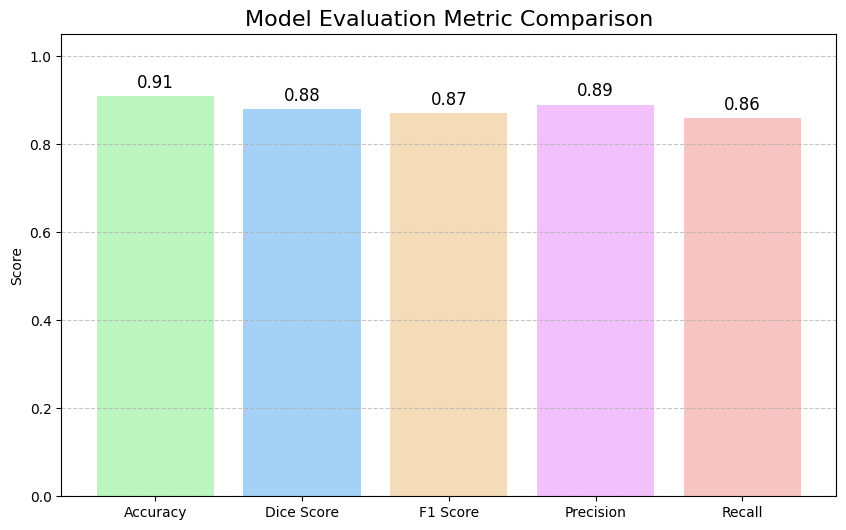

In [ ]:
import matplotlib.pyplot as plt

# Sample values from model.evaluate — replace with your actual values
metric_names = ['Accuracy', 'Dice Score', 'F1 Score', 'Precision', 'Recall']
metric_values = [0.91, 0.88, 0.87, 0.89, 0.86]  # Replace with your actual results

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names, metric_values, color=['#bcf5bf', '#a4d1f5', '#f5dcb8', '#f2c0fa', '#f7c5c1'])

# Add text labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Styling
plt.ylim(0, 1.05)
plt.title('Model Evaluation Metric Comparison', fontsize=16)
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display_sample_predictions(dataset, model, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images, verbose=0)
        preds = tf.argmax(preds, axis=-1)
        preds = tf.cast(preds, tf.uint8)  # Convert to uint8 for display

        images = images.numpy()
        masks = masks.numpy()
        preds = preds.numpy()

        for i in range(num):
            plt.figure(figsize=(12, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].squeeze(), cmap='gray', vmin=0, vmax=3)
            plt.title("True Mask")
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(preds[i], cmap='gray', vmin=0, vmax=3)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

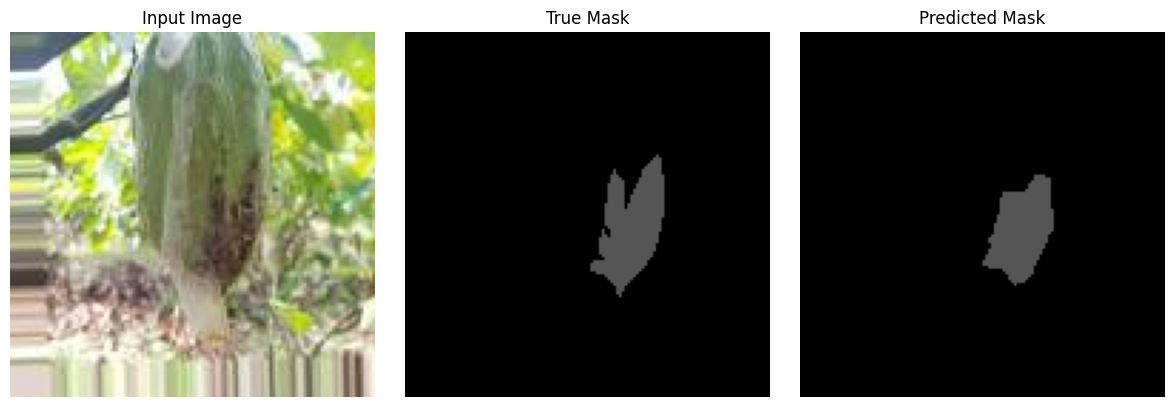

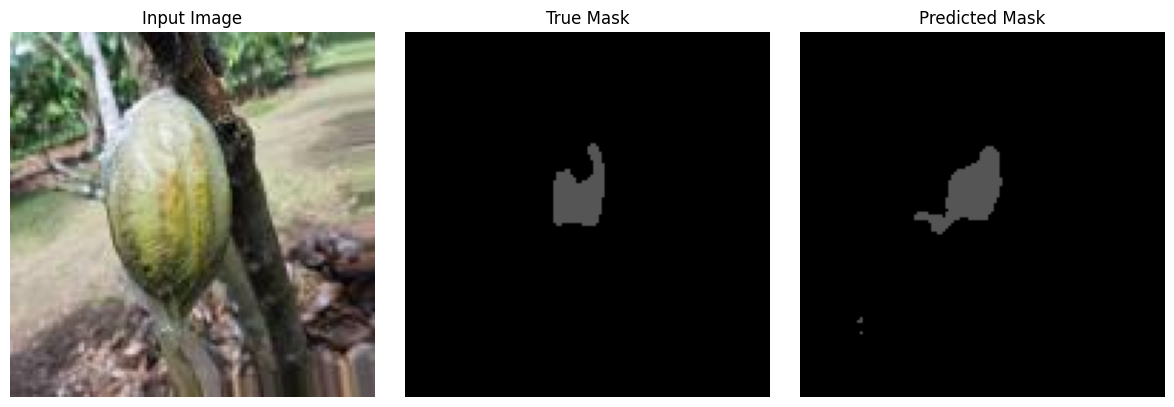

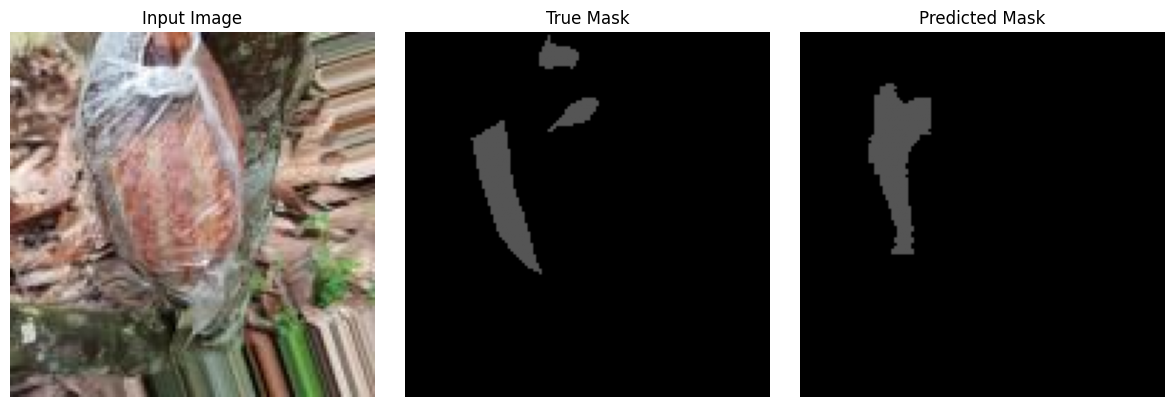

In [ ]:
display_sample_predictions(val_dataset, model, num=3)

Saving cocoa-bean-63177_960_720-removebg-preview.png to cocoa-bean-63177_960_720-removebg-preview (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


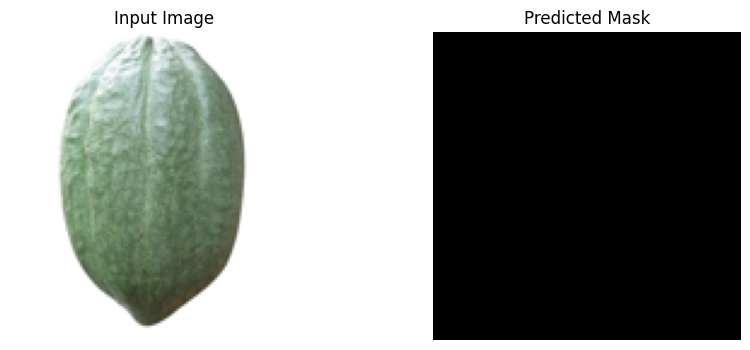

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load model
model = load_model('/content/drive/MyDrive/segmentation_model_secound_updated.keras')

# Upload image
uploaded = files.upload()

# Load the uploaded image
for filename in uploaded.keys():
    image_path = filename
    image = Image.open(image_path).convert("RGB")
    image = image.resize((128, 128))
    input_image = np.array(image) / 255.0  # Normalize
    input_tensor = tf.expand_dims(input_image, axis=0)  # Add batch dimension

    # Predict mask
    prediction = model.predict(input_tensor)
    predicted_mask = tf.argmax(prediction, axis=-1)
    predicted_mask = predicted_mask[0]  # remove batch dim

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask.numpy(), cmap='gray', vmin=0, vmax=3)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

###Segmentation Model - Overlapping Algorithm

Saving cocoa-bean-63177_960_720-removebg-preview.png to cocoa-bean-63177_960_720-removebg-preview (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


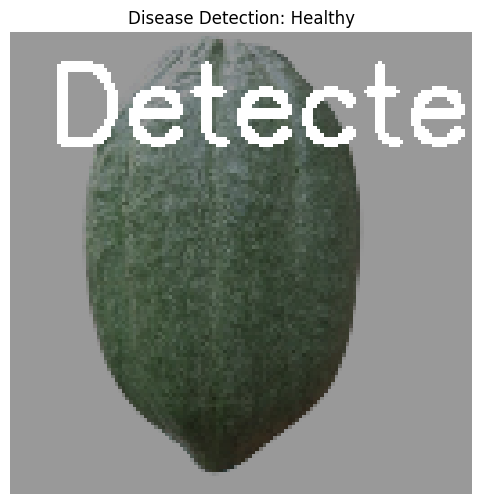

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
import cv2

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load and preprocess image
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (128, 128))  # Resize to model input
input_image = original_image.astype('float32') / 255.0
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Load model
model = load_model('/content/drive/MyDrive/segmentation_model_secound_updated.keras')

# Predict the segmentation mask
mask_pred = model.predict(input_image)
mask_pred = np.argmax(mask_pred, axis=-1)[0]  # (128, 128)

# Define class labels
LABEL_MAP = {
    0: "Background",
    1: "Healthy",
    2: "Black Pod Rot",
    3: "Pod Borer"
}

# Assign class colors
CLASS_COLORS = {
    0: (0, 0, 0),         # Background
    1: (0, 255, 0),       # Healthy
    2: (255, 0, 0),       # Black Pod Rot
    3: (0, 0, 255)        # Pod Borer
}

# Identify disease types from the predicted mask
def identify_disease_from_mask(mask):
    classes_in_mask = np.unique(mask)
    disease_labels = []

    for cls in classes_in_mask:
        if cls == 0:  # Background
            continue
        label = LABEL_MAP.get(cls, "Unknown")
        disease_labels.append(label)

    if not disease_labels:
        return ["Healthy"]
    return disease_labels

# Visualize with overlay
def visualize_segmentation(original_image, mask):
    color_mask = np.zeros_like(original_image)

    for class_idx, color in CLASS_COLORS.items():
        color_mask[mask == class_idx] = color

    overlay = cv2.addWeighted(original_image, 0.6, color_mask, 0.4, 0)

    diseases = identify_disease_from_mask(mask)
    label_text = ', '.join(diseases)

    cv2.putText(overlay, f"Detected: {label_text}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Disease Detection: {label_text}")
    plt.show()

# Run visualization
visualize_segmentation(original_image, mask_pred)


In [ ]:
print("Unique values in predicted mask:", np.unique(mask_pred))

Unique values in predicted mask: [0 1]


In [ ]:
import numpy as np
import os
from glob import glob
import cv2

mask_paths = glob('/content/drive/MyDrive/cocoaSegmentation/images/val/*.jpg')  # <-- adjust path

class_counts = {0: 0, 1: 0, 2: 0, 3: 0}

for path in mask_paths:
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        if u in class_counts:
            class_counts[u] += c

print("Total pixel counts per class:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count}")

Total pixel counts per class:
Class 0: 250882
Class 1: 576350
Class 2: 865751
Class 3: 956066


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

sample_mask_path = '/content/drive/MyDrive/cocoa_segmentation/masks/train/image_1_jpg.rf.c70dabbd67f5cfe1613aa9606a3cba7f_mask.png'  # replace with a real file

mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

if mask is None:
    print("❌ Failed to load mask image. Check file path.")
else:
    print("✅ Mask loaded successfully. Unique values:", np.unique(mask))
    plt.imshow(mask, cmap='gray')
    plt.title("Mask Preview")
    plt.colorbar()
    plt.show()

❌ Failed to load mask image. Check file path.


Analysis started at (UTC): 2025-07-25 06:43:30
🔍 COCOA POD DISEASE ANALYSIS
Please upload a cocoa pod image...


Saving Cacao__Theobromae_cacao__Black_pod_rot_29398718150_o-removebg-preview.png to Cacao__Theobromae_cacao__Black_pod_rot_29398718150_o-removebg-preview (4).png
✅ Analyzing: Cacao__Theobromae_cacao__Black_pod_rot_29398718150_o-removebg-preview (4).png


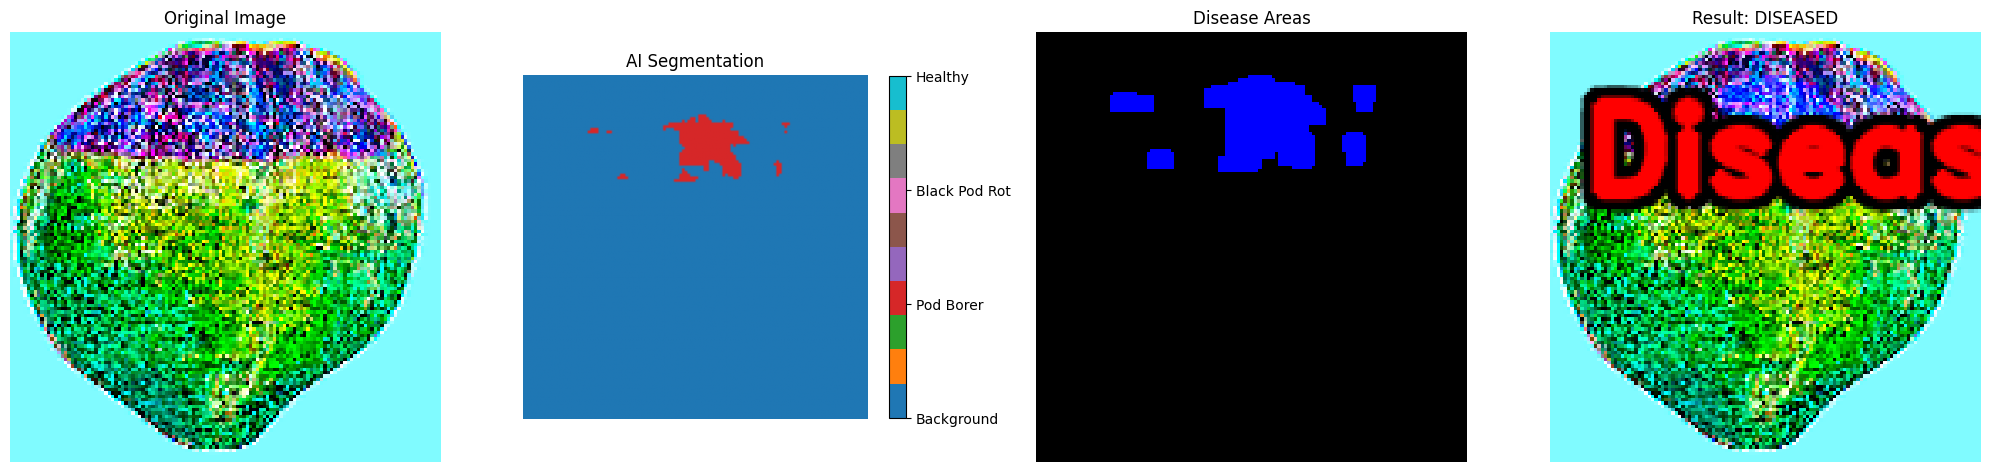


ANALYSIS RESULTS
🔴 DISEASED COCOA POD
   • Disease detected: Pod Borer
   • Red/Blue areas show disease locations
   • Immediate attention required


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
from google.colab import files
from datetime import datetime

# Constants
IMG_SIZE = (128, 128)
NUM_CLASSES = 4

# Updated class labels and colors
LABEL_MAP = {
    0: "Background",
    1: "Pod Borer",
    2: "Black Pod Rot",
    3: "Healthy"
}

# Only disease classes get colored overlays
DISEASE_COLORS = {
    1: (0, 0, 255),      # Pod Borer - Blue
    2: (255, 0, 0)       # Black Pod Rot - Red
}

def load_dataset(image_dir, mask_dir, batch_size=8):
    try:
        image_dataset = tf.data.Dataset.list_files(f"{image_dir}/*.jpg")
        mask_dataset = tf.data.Dataset.list_files(f"{mask_dir}/*.png")
        dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

        def load_and_preprocess(img_path, mask_path):
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, IMG_SIZE)
            img = tf.cast(img, tf.float32) / 255.0

            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.resize(mask, IMG_SIZE, method='nearest')

            return img, mask

        dataset = dataset.map(load_and_preprocess)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Failed to load image")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)

    a = cv2.normalize(a, None, 0, 255, cv2.NORM_MINMAX)
    b = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX)

    enhanced = cv2.merge((l,a,b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    resized = cv2.resize(enhanced, target_size, interpolation=cv2.INTER_LANCZOS4)
    normalized = resized.astype('float32') / 255.0

    return normalized, resized

def analyze_mask_for_diseases(mask):
    unique_values, counts = np.unique(mask, return_counts=True)
    total_pixels = mask.shape[0] * mask.shape[1]

    MIN_DISEASE_PIXELS = 30
    MIN_HEALTHY_PERCENTAGE = 20.0

    has_healthy = False
    diseases_found = []
    class_percentages = {}

    for val, count in zip(unique_values, counts):
        percentage = (count / total_pixels) * 100
        label = LABEL_MAP.get(val, f"Unknown class {val}")

        if val in [1, 2]:  # Pod Borer or Black Pod Rot
            if count > MIN_DISEASE_PIXELS:
                diseases_found.append(label)
        elif val == 3:  # Healthy
            if percentage > MIN_HEALTHY_PERCENTAGE:
                has_healthy = True

    if diseases_found:
        has_healthy = False

    return has_healthy, diseases_found

def create_disease_overlay(original_image, mask, has_healthy, diseases_found):
    result_image = original_image.copy()
    disease_only = np.zeros_like(original_image)
    OVERLAY_ALPHA = 0.8

    if diseases_found:
        for class_idx, color in DISEASE_COLORS.items():
            if LABEL_MAP[class_idx] in diseases_found:
                disease_areas = (mask == class_idx)

                kernel = np.ones((5,5), np.uint8)
                disease_areas = cv2.dilate(disease_areas.astype(np.uint8), kernel, iterations=1)

                colored_area = np.array(color, dtype=np.uint8)
                disease_only[disease_areas == 1] = colored_area

                overlay = np.zeros_like(original_image)
                overlay[disease_areas == 1] = colored_area

                result_image = cv2.addWeighted(
                    result_image, 1.0,
                    overlay, OVERLAY_ALPHA,
                    0
                )

    if diseases_found:
        status = "DISEASED"
        status_text = f"Disease: {', '.join(diseases_found)}"
        text_color = (255, 0, 0)
    else:
        status = "HEALTHY"
        status_text = "Healthy Pod"
        text_color = (0, 255, 0)

    font = cv2.FONT_HERSHEY_DUPLEX
    font_scale = 1.2
    thickness = 3
    text_size = cv2.getTextSize(status_text, font, font_scale, thickness)[0]
    text_x = 10
    text_y = text_size[1] + 20

    for dx, dy in [(-2,-2), (-2,2), (2,-2), (2,2)]:
        cv2.putText(result_image, status_text,
                   (text_x+dx, text_y+dy),
                   font, font_scale, (0,0,0), thickness+2, cv2.LINE_AA)

    cv2.putText(result_image, status_text,
                (text_x, text_y),
                font, font_scale, text_color, thickness, cv2.LINE_AA)

    return result_image, disease_only, status, status_text

def analyze_cocoa_pod():
    print(f"Analysis started at (UTC): {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
    print("🔍 COCOA POD DISEASE ANALYSIS")
    print("="*50)

    print("Please upload a cocoa pod image...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    image_path = list(uploaded.keys())[0]
    print(f"✅ Analyzing: {image_path}")

    try:
        input_image, original_resized = preprocess_image(image_path, IMG_SIZE)
        input_image = np.expand_dims(input_image, axis=0)

        model = load_model('/content/drive/MyDrive/segmentation_model_secound_updated.keras')
        mask_pred = model.predict(input_image, verbose=0)
        mask_pred = np.argmax(mask_pred, axis=-1)[0]

        disease_only = np.zeros_like(original_resized)
        for class_idx, color in DISEASE_COLORS.items():
            disease_only[mask_pred == class_idx] = color

        HEALTHY_COLOR = (0, 255, 0)
        disease_only[mask_pred == 3] = HEALTHY_COLOR  # 3 = Healthy

        has_healthy, diseases_found = analyze_mask_for_diseases(mask_pred)

        result_image, disease_only, status, status_text = create_disease_overlay(
            original_resized, mask_pred, has_healthy, diseases_found
        )

        plt.figure(figsize=(20, 6))

        plt.subplot(1, 4, 1)
        plt.imshow(original_resized)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(mask_pred, cmap='tab10', vmin=0, vmax=3)
        plt.title("AI Segmentation")
        plt.axis('off')
        cbar = plt.colorbar(shrink=0.6)
        cbar.set_ticks([0, 1, 2, 3])
        cbar.set_ticklabels(['Background', 'Pod Borer', 'Black Pod Rot', 'Healthy'])

        plt.subplot(1, 4, 3)
        plt.imshow(disease_only)
        plt.title("Disease Areas")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(result_image)
        plt.title(f"Result: {status}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print("\n" + "="*50)
        print("ANALYSIS RESULTS")
        print("="*50)

        if diseases_found:
            print("🔴 DISEASED COCOA POD")
            print(f"   • Disease detected: {', '.join(diseases_found)}")
            print("   • Red/Blue areas show disease locations")
            print("   • Immediate attention required")
        else:
            print("✅ HEALTHY COCOA POD")
            print("   • No disease symptoms detected")
            print("   • Pod appears to be in good condition")

        print("="*50)

    except Exception as e:
        print(f"❌ Error during analysis: {str(e)}")
        return None, None

    return status, diseases_found

if __name__ == "__main__":
    analyze_cocoa_pod()


In [ ]:
from glob import glob
import cv2
import numpy as np

mask_paths = glob('/content/drive/MyDrive/cocoaSegmentation/masks/train/*.png')

for path in mask_paths:
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"❌ Couldn't load {path}")
        continue

    # Check if label values are valid
    unique_vals = np.unique(mask)
    if not set(unique_vals).issubset({0, 1, 2, 3}):
        print(f"🚨 Invalid labels in {path}: {unique_vals}")
    else:
        print(f"✅ {path} - OK")


✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_332_jpg.rf.82ddc0360b8e5da1cbf2d0e727efcc13_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_333_jpg.rf.a2ec5da7435cc04aa01147e05590e764_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_333_jpg.rf.c1ee10a420a93bb5c35de548d60cfefb_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_334_jpg.rf.eec99dced7a69afaab359dd4e18f5b24_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_335_jpg.rf.68cf38f1eb6a01ee753455b896109e53_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_336_jpg.rf.731ba8c996b84673db1507234e4d28e6_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_337_jpg.rf.ae67576bba6a4e80748af5e2310ecdea_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks/train/image_338_jpg.rf.a06ad686dd67f7cdd84a8cd03bcfd61f_mask.png - OK
✅ /content/drive/MyDrive/cocoaSegmentation/masks

In [ ]:
print("⚠️ Predicted mask classes:", np.unique(mask_pred))

⚠️ Predicted mask classes: [0 1]


In [ ]:
from glob import glob
import cv2
import numpy as np

mask_paths = glob('/content/drive/MyDrive/cocoaSegmentation/images/train/*.jpg')

class_counts = {0: 0, 1: 0, 2: 0, 3: 0}

for path in mask_paths:
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            if u in class_counts:
                class_counts[u] += c

print("🧪 Pixel counts per class:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count}")


🧪 Pixel counts per class:
Class 0: 1187618
Class 1: 3010302
Class 2: 3259528
Class 3: 3094711
